<a href="https://colab.research.google.com/github/carolsworld/DeepfakeDetector/blob/main/3_deepfakedetection_utilimateTestWildDeepfakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is a notebook for using all trained models for final testing to check its effectiveness of classifying real videos or deepfake videos in the wild**

## Step 1 - In a new Google Colab notebook, turn on GPU in runtime

In [1]:
# Check GPU information 
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  9 09:18:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Step 2 - Upload the video and model to Google Drive

Create several folders in [Google Drive](https://drive.google.com/drive/my-drive) 

Save the videos (.mp4) and model (.h5) inside the following three folders:

*  My Drive/MyVideo/Real/yourrealvideo.mp4
*  My Drive/MyVideo/Fake/yourfakevideo.mp4
*  My Drive/MyModel/my_ResNet152V2.h5

Also create the following folders for keeping the frames and chopped faces during image processing.

* My Drive/MyVideo/Frames/Real/realframestobecreated.jpg
* My Drive/MyVideo/Frames/Fake/fakeframestobecreated.jpg
* My Drive/MyVideo/Faces/Real/realfacestobecreated.jpg
* My Drive/MyVideo/Faces/Fake/fakefacestobecreated.jpg

In [2]:
# Confirm Google Drive is connected with Google Colab
google = !if [ -d 'GDrive/' ]; then echo "1" ; else echo "0"; fi
if (google[0] is '0' ):
  from google.colab import drive
  drive.mount('/content/GDrive/')
  
!if [ -d 'GDrive/' ]; then echo "Connection to Google drive successful" ; else echo "Error to connect to Google drive"; fi

Mounted at /content/GDrive/
Connection to Google drive successful


In [6]:
# List the video files and model in Google drive which are to be transferred to a temporary directory in Google Colab
!ls GDrive/My\ Drive/MyVideo/Real/
!ls GDrive/My\ Drive/MyVideo/Fake/
!ls GDrive/My\ Drive/MyModel/

BO_1.mp4  EM_1.mp4  JL_1.mp4  QE_1.mp4	TC_1.mp4
BO_0.mp4  EM_0.mp4  JL_0.mp4  QE_0.mp4	TC_0.mp4
my_DenseNet.h5	      my_InceptionResNetModel.h5  my_VGG19.h5
my_EfficientNetB3.h5  my_MobileNetModel.h5	  my_Xeception.h5
my_EfficientNetB7.h5  my_NASNetMobile.h5
my_InceptionNetV3.h5  my_ResNet152V2.h5


## Step 3 - Create a temporary directory in Google Colab. Copy the mp4 files and the model from your Google Drive to Google Colab

In [7]:
# Set up environment and import libraries in Google Colab
!pip install --upgrade pip > /dev/null
!pip install scikit-image
!pip install opencv-python

In [8]:
# Import libraries and modules in Google Colab
import cv2
from skimage.transform import resize
import matplotlib.pyplot as plt
import math
import os 

In [9]:
# Make a temporarty directory in Google colab
!mkdir -p /content/DetectionTest/Sources/Real > /dev/null
!mkdir -p /content/DetectionTest/Sources/Fake > /dev/null
!mkdir -p /content/DetectionTest/Sources/frames/real > /dev/null
!mkdir -p /content/DetectionTest/Sources/frames/fake > /dev/null
!mkdir -p /content/DetectionTest/Sources/faces/real > /dev/null
!mkdir -p /content/DetectionTest/Sources/faces/fake > /dev/null
!mkdir -p /content/DetectionTest/Model > /dev/null

# copy video stored in Google Drive to Google Colab
!cp GDrive/My\ Drive/MyVideo/Real/*.mp4 DetectionTest/Sources/Real/
!cp GDrive/My\ Drive/MyVideo/Fake/*.mp4 DetectionTest/Sources/Fake/

# copy model stored in Google Drive to Google Colab
!cp GDrive/My\ Drive/MyModel/*.h5 DetectionTest/Model/

# List files Google Colab's temporary directory 
!ls /content/DetectionTest/Sources/Real
!ls /content/DetectionTest/Sources/Fake
!ls /content/DetectionTest/Model

BO_1.mp4  EM_1.mp4  JL_1.mp4  QE_1.mp4	TC_1.mp4
BO_0.mp4  EM_0.mp4  JL_0.mp4  QE_0.mp4	TC_0.mp4
my_DenseNet.h5	      my_InceptionResNetModel.h5  my_VGG19.h5
my_EfficientNetB3.h5  my_MobileNetModel.h5	  my_Xeception.h5
my_EfficientNetB7.h5  my_NASNetMobile.h5
my_InceptionNetV3.h5  my_ResNet152V2.h5


## Step 4 - Extract frames from the video

### Real videos

In [10]:
# Folder path contains the videos
INPUT_VIDEOS_PATH = '/content/DetectionTest/Sources/Real'

# Folder path for storing image frames to be extracted from videos
OUTPUT_FRAMES_PATH = '/content/DetectionTest/Sources/frames/real'

# Create variables  
one_frame_each = 120                                                            # Para = 24, Extract 1 frame from a video for every 24 frames, around 1 second (DFDpreview)

!if [ -d {OUTPUT_FRAMES_PATH} ]; then echo "Output to be stored in "{OUTPUT_FRAMES_PATH} ; else mkdir {OUTPUT_FRAMES_PATH} && echo "Output directory created"; fi

videofiles = !ls {INPUT_VIDEOS_PATH}/*.mp4                                      # Video file names in INPUT VIDEOS PATH

Output to be stored in /content/DetectionTest/Sources/frames/real


In [11]:
for videofile in videofiles:
    count = 0
    success = True
    filename = os.path.basename(videofile)
    vidcap = cv2.VideoCapture(videofile)

    while success:
        if (count%one_frame_each == 0):                                             # checks frame number and keeps one_frame_each          
            success, image = vidcap.read()                                           # reads next frame           
            if image.shape[1]>640:                                                  # if image width > 640, resize it
                tmp = resize(image, (math.floor(640 / image.shape[1] * image.shape[0]), 640))
            plt.imsave("%s/%s%d.jpg" % (OUTPUT_FRAMES_PATH,filename,count), tmp, format='jpg') # saves images to frame folder
            print ('*', end="")
        else:
            success,image = vidcap.read()                                           # reads next frame
        count += 1                                                                  # loops counter


**************

In [12]:
# List the image frames in Google Colab's temporary directory 
!ls /content/DetectionTest/Sources/frames/real

# Copy the frames to Google Drive
!cp /content/DetectionTest/Sources/frames/real/* GDrive/My\ Drive/MyVideo/Frames/Real


BO_1.mp40.jpg	 EM_1.mp4120.jpg  JL_1.mp4240.jpg  TC_1.mp40.jpg
BO_1.mp4120.jpg  EM_1.mp4240.jpg  QE_1.mp40.jpg    TC_1.mp4120.jpg
BO_1.mp4240.jpg  JL_1.mp40.jpg	  QE_1.mp4120.jpg
EM_1.mp40.jpg	 JL_1.mp4120.jpg  QE_1.mp4240.jpg


In [13]:
# List the image frames in Google Drive 
!ls GDrive/My\ Drive/MyVideo/Frames/Real

BO_1.mp40.jpg	 EM_1.mp4120.jpg  JL_1.mp4240.jpg  TC_1.mp40.jpg
BO_1.mp4120.jpg  EM_1.mp4240.jpg  QE_1.mp40.jpg    TC_1.mp4120.jpg
BO_1.mp4240.jpg  JL_1.mp40.jpg	  QE_1.mp4120.jpg
EM_1.mp40.jpg	 JL_1.mp4120.jpg  QE_1.mp4240.jpg


### Fake videos

In [14]:
# Folder path contains the videos
INPUT_VIDEOS_PATH = '/content/DetectionTest/Sources/Fake'

# Folder path for storing image frames to be extracted from videos
OUTPUT_FRAMES_PATH = '/content/DetectionTest/Sources/frames/fake'

# Create variables  
one_frame_each = 120                                                            # Para = 24, Extract 1 frame from a video for every 24 frames, around 1 second (DFDpreview)

!if [ -d {OUTPUT_FRAMES_PATH} ]; then echo "Output to be stored in "{OUTPUT_FRAMES_PATH} ; else mkdir {OUTPUT_FRAMES_PATH} && echo "Output directory created"; fi

videofiles = !ls {INPUT_VIDEOS_PATH}/*.mp4                                      # Video file names in INPUT VIDEOS PATH

Output to be stored in /content/DetectionTest/Sources/frames/fake


In [15]:
for videofile in videofiles:
    count = 0
    success = True
    filename = os.path.basename(videofile)
    vidcap = cv2.VideoCapture(videofile)

    while success:
        if (count%one_frame_each == 0):                                             # checks frame number and keeps one_frame_each          
            success, image = vidcap.read()                                           # reads next frame           
            if image.shape[1]>640:                                                  # if image width > 640, resize it
                tmp = resize(image, (math.floor(640 / image.shape[1] * image.shape[0]), 640))
            plt.imsave("%s/%s%d.jpg" % (OUTPUT_FRAMES_PATH,filename,count), tmp, format='jpg') # saves images to frame folder
            print ('*', end="")
        else:
            success,image = vidcap.read()                                           # reads next frame
        count += 1                                                                  # loops counter


*************

In [16]:
# List the image frames in Google Colab's temporary directory 
!ls /content/DetectionTest/Sources/frames/fake

# Copy the frames to Google Drive
!cp /content/DetectionTest/Sources/frames/fake/* GDrive/My\ Drive/MyVideo/Frames/Fake


BO_0.mp40.jpg	 JL_0.mp40.jpg	  QE_0.mp4120.jpg  TC_0.mp4240.jpg
BO_0.mp4120.jpg  JL_0.mp4120.jpg  QE_0.mp4240.jpg
EM_0.mp40.jpg	 JL_0.mp4240.jpg  TC_0.mp40.jpg
EM_0.mp4120.jpg  QE_0.mp40.jpg	  TC_0.mp4120.jpg


In [17]:
# List the image frames in Google Drive 
!ls GDrive/My\ Drive/MyVideo/Frames/Fake

BO_0.mp40.jpg	 JL_0.mp40.jpg	  QE_0.mp4120.jpg  TC_0.mp4240.jpg
BO_0.mp4120.jpg  JL_0.mp4120.jpg  QE_0.mp4240.jpg
EM_0.mp40.jpg	 JL_0.mp4240.jpg  TC_0.mp40.jpg
EM_0.mp4120.jpg  QE_0.mp40.jpg	  TC_0.mp4120.jpg


## Step 5 - Extract faces from the frames

In [18]:
!apt-get install build-essential cmake
!apt-get install libopenblas-dev liblapack-dev
!pip install dlib
!pip install face_recognition
!pip install opencv-python
!pip install opencv-contrib-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
liblapack-dev is already the newest version (3.7.1-4ubuntu1).
libopenblas-dev is already the newest version (0.2.20+ds-4).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
     |████████████████████████████████| 100.1 MB 1.2 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=d3af9e71db1a35614aa06dffb69e75f0a379bc6a83bf522811f10d72da6ddf45
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face

In [19]:
# Import OpenCV and face_recognition libraries to extract the faces from frames
from PIL import Image
import cv2
import face_recognition

### Real video images

In [20]:
# Folder path contains the frames
INPUT_FRAMES_PATH = '/content/DetectionTest/Sources/frames/real'

# Folder path for storing faces to be extracted from images
OUTPUT_FACES_PATH = '/content/DetectionTest/Sources/faces/real'

!if [ -d {OUTPUT_FACES_PATH} ]; then echo "Output to be stored in "{OUTPUT_FACES_PATH} ; else mkdir {OUTPUT_FACES_PATH} && echo "Output directory created"; fi

imagefiles = !ls {INPUT_FRAMES_PATH}/*.jpg                                      # Image file names in INPUT FRAMES PATH

# Extract face from all image files in the given directory
for imagefile in imagefiles:
    filename = os.path.basename(imagefile)
    image = face_recognition.load_image_file(imagefile)
    face_locations = face_recognition.face_locations(image)
    print("Found {} face(s) in this photograph - %s.".format(len(face_locations)),filename)

    %matplotlib inline
    plt.rcParams['figure.figsize'] = [32, 8]

    for face_location in face_locations:
        top, right, bottom, left = face_location
        print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {} for %s".format(top, left, bottom, right), filename)
        face_image = image[top:bottom, left:right]

        if(len(face_locations) == 1):
            cv2.imwrite("%s/%sF.jpg" % (OUTPUT_FACES_PATH,filename), face_image)
            print ('*', end="")

Output to be stored in /content/DetectionTest/Sources/faces/real
Found 1 face(s) in this photograph - %s. BO_1.mp40.jpg
A face is located at pixel location Top: 66, Left: 275, Bottom: 156, Right: 364 for %s BO_1.mp40.jpg
*Found 1 face(s) in this photograph - %s. BO_1.mp4120.jpg
A face is located at pixel location Top: 80, Left: 295, Bottom: 155, Right: 370 for %s BO_1.mp4120.jpg
*Found 1 face(s) in this photograph - %s. BO_1.mp4240.jpg
A face is located at pixel location Top: 66, Left: 285, Bottom: 156, Right: 374 for %s BO_1.mp4240.jpg
*Found 1 face(s) in this photograph - %s. EM_1.mp40.jpg
A face is located at pixel location Top: 82, Left: 253, Bottom: 211, Right: 382 for %s EM_1.mp40.jpg
*Found 1 face(s) in this photograph - %s. EM_1.mp4120.jpg
A face is located at pixel location Top: 82, Left: 239, Bottom: 211, Right: 368 for %s EM_1.mp4120.jpg
*Found 1 face(s) in this photograph - %s. EM_1.mp4240.jpg
A face is located at pixel location Top: 64, Left: 253, Bottom: 219, Right: 408 f

In [21]:
# Count number of faces in Google Colab's temporary directory 
!ls /content/DetectionTest/Sources/faces/real | wc -l

14


In [22]:
# List the faces in Google Colab's temporary directory 
!ls /content/DetectionTest/Sources/faces/real

BO_1.mp40.jpgF.jpg    EM_1.mp4240.jpgF.jpg  QE_1.mp4120.jpgF.jpg
BO_1.mp4120.jpgF.jpg  JL_1.mp40.jpgF.jpg    QE_1.mp4240.jpgF.jpg
BO_1.mp4240.jpgF.jpg  JL_1.mp4120.jpgF.jpg  TC_1.mp40.jpgF.jpg
EM_1.mp40.jpgF.jpg    JL_1.mp4240.jpgF.jpg  TC_1.mp4120.jpgF.jpg
EM_1.mp4120.jpgF.jpg  QE_1.mp40.jpgF.jpg


In [23]:
# Copy the faces to Google Drive
!cp /content/DetectionTest/Sources/faces/real/* GDrive/My\ Drive/MyVideo/Faces/Real

In [24]:
# List the faces in Google Drive 
!ls GDrive/My\ Drive/MyVideo/Faces/Real

BO_1.mp40.jpgF.jpg    EM_1.mp4240.jpgF.jpg  QE_1.mp4120.jpgF.jpg
BO_1.mp4120.jpgF.jpg  JL_1.mp40.jpgF.jpg    QE_1.mp4240.jpgF.jpg
BO_1.mp4240.jpgF.jpg  JL_1.mp4120.jpgF.jpg  TC_1.mp40.jpgF.jpg
EM_1.mp40.jpgF.jpg    JL_1.mp4240.jpgF.jpg  TC_1.mp4120.jpgF.jpg
EM_1.mp4120.jpgF.jpg  QE_1.mp40.jpgF.jpg


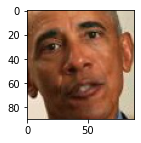

In [25]:
# Visualise the face
plt.figure(figsize = (5,2))
viewreal = plt.imread("/content/DetectionTest/Sources/faces/real/BO_1.mp40.jpgF.jpg")   # update file name
plt.imshow(viewreal)

### Fake video images

In [26]:
# Folder path contains the frames
INPUT_FRAMES_PATH = '/content/DetectionTest/Sources/frames/fake'

# Folder path for storing faces to be extracted from images
OUTPUT_FACES_PATH = '/content/DetectionTest/Sources/faces/fake'

!if [ -d {OUTPUT_FACES_PATH} ]; then echo "Output to be stored in "{OUTPUT_FACES_PATH} ; else mkdir {OUTPUT_FACES_PATH} && echo "Output directory created"; fi

imagefiles = !ls {INPUT_FRAMES_PATH}/*.jpg                                      # Image file names in INPUT FRAMES PATH

# Extract face from all image files in the given directory
for imagefile in imagefiles:
    filename = os.path.basename(imagefile)
    image = face_recognition.load_image_file(imagefile)
    face_locations = face_recognition.face_locations(image)
    print("Found {} face(s) in this photograph - %s.".format(len(face_locations)),filename)

    %matplotlib inline
    plt.rcParams['figure.figsize'] = [32, 8]

    for face_location in face_locations:
        top, right, bottom, left = face_location
        print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {} for %s".format(top, left, bottom, right), filename)
        face_image = image[top:bottom, left:right]

        if(len(face_locations) == 1):
            cv2.imwrite("%s/%sF.jpg" % (OUTPUT_FACES_PATH,filename), face_image)
            print ('*', end="")

Output to be stored in /content/DetectionTest/Sources/faces/fake
Found 1 face(s) in this photograph - %s. BO_0.mp40.jpg
A face is located at pixel location Top: 80, Left: 247, Bottom: 187, Right: 354 for %s BO_0.mp40.jpg
*Found 1 face(s) in this photograph - %s. BO_0.mp4120.jpg
A face is located at pixel location Top: 76, Left: 255, Bottom: 166, Right: 344 for %s BO_0.mp4120.jpg
*Found 1 face(s) in this photograph - %s. EM_0.mp40.jpg
A face is located at pixel location Top: 92, Left: 235, Bottom: 199, Right: 342 for %s EM_0.mp40.jpg
*Found 1 face(s) in this photograph - %s. EM_0.mp4120.jpg
A face is located at pixel location Top: 96, Left: 253, Bottom: 225, Right: 382 for %s EM_0.mp4120.jpg
*Found 1 face(s) in this photograph - %s. JL_0.mp40.jpg
A face is located at pixel location Top: 66, Left: 325, Bottom: 156, Right: 414 for %s JL_0.mp40.jpg
*Found 1 face(s) in this photograph - %s. JL_0.mp4120.jpg
A face is located at pixel location Top: 76, Left: 305, Bottom: 166, Right: 394 for %

In [27]:
# Count number of faces in Google Colab's temporary directory 
!ls /content/DetectionTest/Sources/faces/fake | wc -l

12


In [28]:
# List the faces in Google Colab's temporary directory 
!ls /content/DetectionTest/Sources/faces/fake

BO_0.mp40.jpgF.jpg    JL_0.mp40.jpgF.jpg    QE_0.mp4240.jpgF.jpg
BO_0.mp4120.jpgF.jpg  JL_0.mp4120.jpgF.jpg  TC_0.mp40.jpgF.jpg
EM_0.mp40.jpgF.jpg    JL_0.mp4240.jpgF.jpg  TC_0.mp4120.jpgF.jpg
EM_0.mp4120.jpgF.jpg  QE_0.mp4120.jpgF.jpg  TC_0.mp4240.jpgF.jpg


In [29]:
# Copy the faces to Google Drive
!cp /content/DetectionTest/Sources/faces/fake/* GDrive/My\ Drive/MyVideo/Faces/Fake

In [30]:
# List the faces in Google Drive 
!ls GDrive/My\ Drive/MyVideo/Faces/Fake

BO_0.mp40.jpgF.jpg    JL_0.mp40.jpgF.jpg    QE_0.mp4240.jpgF.jpg
BO_0.mp4120.jpgF.jpg  JL_0.mp4120.jpgF.jpg  TC_0.mp40.jpgF.jpg
EM_0.mp40.jpgF.jpg    JL_0.mp4240.jpgF.jpg  TC_0.mp4120.jpgF.jpg
EM_0.mp4120.jpgF.jpg  QE_0.mp4120.jpgF.jpg  TC_0.mp4240.jpgF.jpg


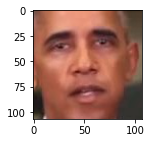

In [31]:
# Visualise the face
plt.figure(figsize = (5,2))
viewreal = plt.imread("/content/DetectionTest/Sources/faces/fake/BO_0.mp40.jpgF.jpg")   # update file name
plt.imshow(viewreal)

## Step 6 - Create my test dataset

In [39]:
import numpy as np
import tensorflow
from tensorflow import keras

In [33]:
# Set path 
base_dir = '/content/DetectionTest/Sources/'
test_dir = os.path.join(base_dir, 'faces')

# Directory with our test fake pictures
test_fake_dir = os.path.join(test_dir, 'fake')

# Directory with our test real pictures
test_real_dir = os.path.join(test_dir, 'real')

# Print some file names to confirm the right directories are connected 
test_real_fnames = os.listdir(test_real_dir)
test_real_fnames.sort()
print(test_real_fnames[:5])

test_fake_fnames = os.listdir(test_fake_dir)
test_fake_fnames.sort()
print(test_fake_fnames[:5])

# Count the number of real and fake images of faces in the train and validation directories
print('total real video images for testing:', len(os.listdir(test_real_dir)))
print('total fake video images for testing:', len(os.listdir(test_fake_dir)))

['BO_1.mp40.jpgF.jpg', 'BO_1.mp4120.jpgF.jpg', 'BO_1.mp4240.jpgF.jpg', 'EM_1.mp40.jpgF.jpg', 'EM_1.mp4120.jpgF.jpg']
['BO_0.mp40.jpgF.jpg', 'BO_0.mp4120.jpgF.jpg', 'EM_0.mp40.jpgF.jpg', 'EM_0.mp4120.jpgF.jpg', 'JL_0.mp40.jpgF.jpg']
total real video images for testing: 14
total fake video images for testing: 12


In [34]:
# Define matplotlib parameters for output images as 4x4 images
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 4
ncols = 4

pic_index = 0                               # index for image iteration

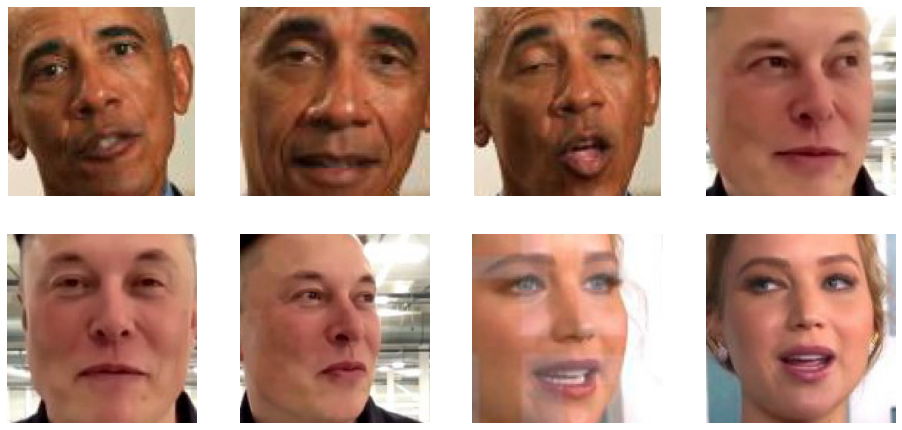

In [35]:
# Show a batch of 8 real images 
# Rerun the cell to fetch a new batch of images 

fig = plt.gcf()                               # set up matplotlib fig
fig.set_size_inches(ncols * 4, nrows * 4)     # size matplotlib fig to fit into a 4x4 image

pic_index += 8
next_real_pix = [os.path.join(test_real_dir, fname) 
                for fname in test_real_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_real_pix):
  sp = plt.subplot(nrows, ncols, i + 1)       # Set up subplot, subplot indices start at 1
  sp.axis('Off')                              # Turn off axis

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [36]:
pic_index = 0                               # reset index for image iteration for fake images

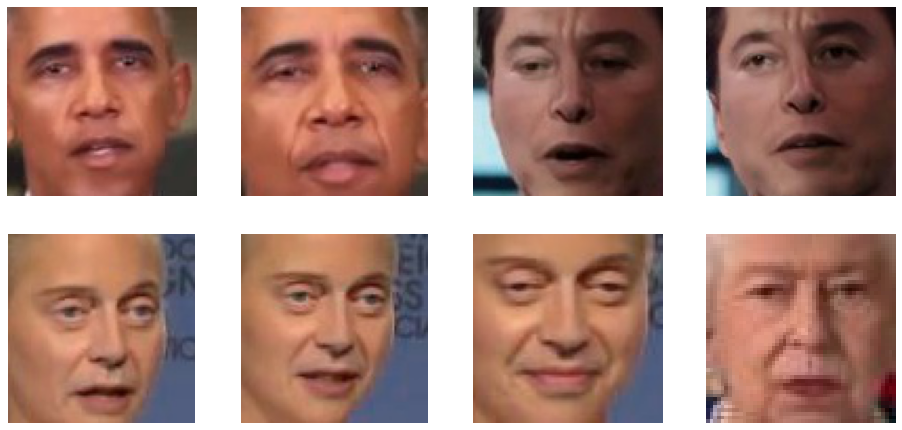

In [37]:
# Show a batch of 8 fake images
# Rerun the cell to fetch a new batch of images 

fig = plt.gcf()                               # set up matplotlib fig
fig.set_size_inches(ncols * 4, nrows * 4)     # size matplotlib fig to fit into a 4x4 image

pic_index += 8
next_fake_pix = [os.path.join(test_fake_dir, fname) 
                for fname in test_fake_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_fake_pix):
  sp = plt.subplot(nrows, ncols, i + 1)       # Set up subplot, subplot indices start at 1
  sp.axis('Off')                              # Turn off axis

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [40]:
BATCH_SIZE = 40
IMG_SIZE = (150, 150)

# Create test dataset with dataset from directory method
test_dataset = tensorflow.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 26 files belonging to 2 classes.


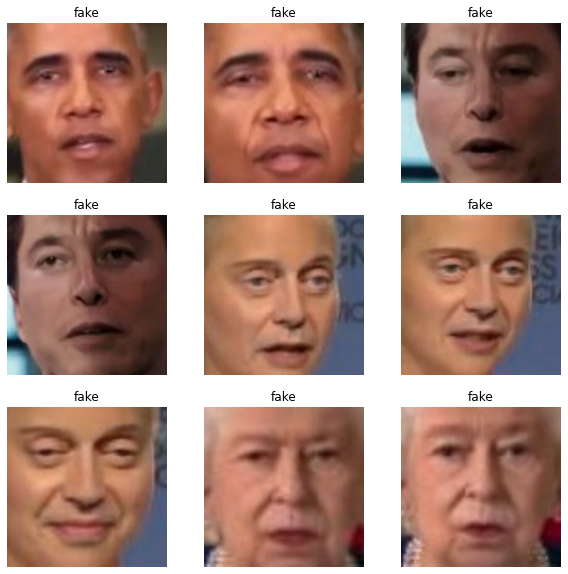

In [41]:
# Check the result of test dataset
class_names = test_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [42]:
# Performance enhancement
AUTOTUNE = tensorflow.data.AUTOTUNE

test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Step 7 - Load the Model

In [44]:
# List the models in Google Colab's temporary directory 
!ls -la /content/DetectionTest/Model

total 2013040
drwxr-xr-x 2 root root      4096 Dec  9 09:24 .
drwxr-xr-x 4 root root      4096 Dec  9 09:24 ..
-rw------- 1 root root 144739920 Dec  9 09:24 my_DenseNet.h5
-rw------- 1 root root  86592688 Dec  9 09:24 my_EfficientNetB3.h5
-rw------- 1 root root 513642616 Dec  9 09:24 my_EfficientNetB7.h5
-rw------- 1 root root 166580856 Dec  9 09:24 my_InceptionNetV3.h5
-rw------- 1 root root 433641880 Dec  9 09:24 my_InceptionResNetModel.h5
-rw------- 1 root root  16919968 Dec  9 09:24 my_MobileNetModel.h5
-rw------- 1 root root  36567648 Dec  9 09:24 my_NASNetMobile.h5
-rw------- 1 root root 460713944 Dec  9 09:24 my_ResNet152V2.h5
-rw------- 1 root root  80178680 Dec  9 09:24 my_VGG19.h5
-rw------- 1 root root 121727000 Dec  9 09:24 my_Xeception.h5


In [45]:
# Load models
modelM1 = keras.models.load_model('/content/DetectionTest/Model/my_Xeception.h5')
modelM2 = keras.models.load_model('/content/DetectionTest/Model/my_VGG19.h5')
modelM3 = keras.models.load_model('/content/DetectionTest/Model/my_ResNet152V2.h5')
modelM4 = keras.models.load_model('/content/DetectionTest/Model/my_InceptionNetV3.h5')
modelM5 = keras.models.load_model('/content/DetectionTest/Model/my_InceptionResNetModel.h5')
modelM6 = keras.models.load_model('/content/DetectionTest/Model/my_MobileNetModel.h5')
modelM7 = keras.models.load_model('/content/DetectionTest/Model/my_DenseNet.h5')
modelM8 = keras.models.load_model('/content/DetectionTest/Model/my_NASNetMobile.h5')
modelM9 = keras.models.load_model('/content/DetectionTest/Model/my_EfficientNetB3.h5')
modelM10 = keras.models.load_model('/content/DetectionTest/Model/my_EfficientNetB7.h5')

In [47]:
modelM1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [48]:
modelM2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 150, 150, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [49]:
modelM3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 resnet152v2 (Functional)    (None, 5, 5, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [50]:
modelM4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [51]:
modelM5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                             

In [52]:
modelM6.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [53]:
modelM7.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 150, 150, 3)      0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 4, 4, 1920)        183219

In [54]:
modelM8.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d (G  (None, 1056)             0     

In [55]:
modelM9.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 5, 5, 1536)       10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                             

In [56]:
modelM10.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 5, 5, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 1)                 2561      
                                                             

## Step 8 - Make prediction with unseen test dataset from the wild

In [58]:
loss, accuracy = modelM1.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 8s 8s/step - loss: 0.8578 - accuracy: 0.6538
Test accuracy : 0.6538461446762085


In [59]:
loss, accuracy = modelM2.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 1s/step - loss: 0.6524 - accuracy: 0.6538
Test accuracy : 0.6538461446762085


In [60]:
loss, accuracy = modelM3.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 2s 2s/step - loss: 2.8144 - accuracy: 0.6538
Test accuracy : 0.6538461446762085


In [61]:
loss, accuracy = modelM4.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 1s/step - loss: 2.9405 - accuracy: 0.6923
Test accuracy : 0.692307710647583


In [62]:
loss, accuracy = modelM5.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 3s 3s/step - loss: 3.1116 - accuracy: 0.6538
Test accuracy : 0.6538461446762085


In [69]:
IMG_SIZE = (160, 160)


# Create test dataset with dataset from directory method
test_dataset = tensorflow.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

# Performance enhancement
AUTOTUNE = tensorflow.data.AUTOTUNE

test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


loss, accuracy = modelM6.evaluate(test_dataset)
print('Test accuracy :', accuracy)

Found 26 files belonging to 2 classes.
1/1 [==============================] - 1s 832ms/step - loss: 0.9838 - accuracy: 0.7308
Test accuracy : 0.7307692170143127


In [64]:
loss, accuracy = modelM7.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 3s 3s/step - loss: 2.7244 - accuracy: 0.6538
Test accuracy : 0.6538461446762085


In [70]:
IMG_SIZE = (224, 224)

# Create test dataset with dataset from directory method
test_dataset = tensorflow.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

# Performance enhancement
AUTOTUNE = tensorflow.data.AUTOTUNE

test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


loss, accuracy = modelM8.evaluate(test_dataset)
print('Test accuracy :', accuracy)

Found 26 files belonging to 2 classes.
1/1 [==============================] - 3s 3s/step - loss: 0.8920 - accuracy: 0.7308
Test accuracy : 0.7307692170143127


In [66]:
loss, accuracy = modelM9.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 2s 2s/step - loss: 1.7097 - accuracy: 0.6923
Test accuracy : 0.692307710647583


In [67]:
loss, accuracy = modelM10.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 5s 5s/step - loss: 1.5947 - accuracy: 0.6154
Test accuracy : 0.6153846383094788


Predictions:
 [1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


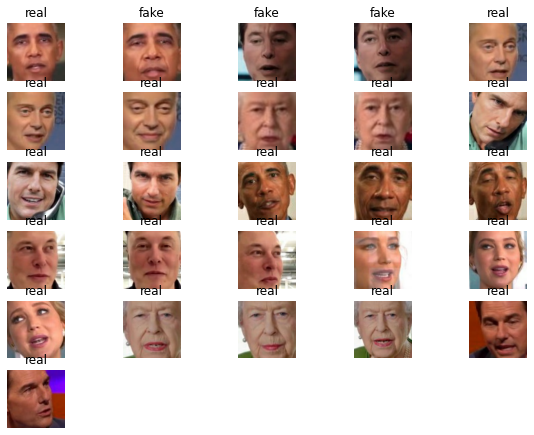

In [ ]:
# Demonstration for model M3 ResNet152V2

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tensorflow.nn.sigmoid(predictions)
predictions = tensorflow.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(26):
  ax = plt.subplot(8, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Step 9 - Image level testing

### Image size setting for models

Setting to be updated before testing model M6 and M8.

In [73]:
# For all models, except for model M6 and M8
IMG_SIZE = (150, 150)

# Create test dataset with dataset from directory method
test_dataset = tensorflow.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

# Performance enhancement
AUTOTUNE = tensorflow.data.AUTOTUNE

test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 26 files belonging to 2 classes.


In [107]:
# For model M6
IMG_SIZE = (160, 160)

# Create test dataset with dataset from directory method
test_dataset = tensorflow.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

# Performance enhancement
AUTOTUNE = tensorflow.data.AUTOTUNE

test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 26 files belonging to 2 classes.


In [111]:
# For model M8
IMG_SIZE = (224, 224)

# Create test dataset with dataset from directory method
test_dataset = tensorflow.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

# Performance enhancement
AUTOTUNE = tensorflow.data.AUTOTUNE

test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 26 files belonging to 2 classes.


### Testing

#### Model M1

In [76]:
# Upload the real faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Real/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM1.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_1.mp40.jpgF.jpg to BO_1.mp40.jpgF.jpg
Saving BO_1.mp4120.jpgF.jpg to BO_1.mp4120.jpgF.jpg
Saving BO_1.mp4240.jpgF.jpg to BO_1.mp4240.jpgF.jpg
Saving EM_1.mp40.jpgF.jpg to EM_1.mp40.jpgF.jpg
Saving EM_1.mp4120.jpgF.jpg to EM_1.mp4120.jpgF.jpg
Saving EM_1.mp4240.jpgF.jpg to EM_1.mp4240.jpgF.jpg
Saving JL_1.mp40.jpgF.jpg to JL_1.mp40.jpgF.jpg
Saving JL_1.mp4120.jpgF.jpg to JL_1.mp4120.jpgF.jpg
Saving JL_1.mp4240.jpgF.jpg to JL_1.mp4240.jpgF.jpg
Saving QE_1.mp40.jpgF.jpg to QE_1.mp40.jpgF.jpg
Saving QE_1.mp4120.jpgF.jpg to QE_1.mp4120.jpgF.jpg
Saving QE_1.mp4240.jpgF.jpg to QE_1.mp4240.jpgF.jpg
Saving TC_1.mp40.jpgF.jpg to TC_1.mp40.jpgF.jpg
Saving TC_1.mp4120.jpgF.jpg to TC_1.mp4120.jpgF.jpg
BO_1.mp40.jpgF.jpg is real
BO_1.mp4120.jpgF.jpg is deepfake
BO_1.mp4240.jpgF.jpg is real
EM_1.mp40.jpgF.jpg is real
EM_1.mp4120.jpgF.jpg is real
EM_1.mp4240.jpgF.jpg is real
JL_1.mp40.jpgF.jpg is real
JL_1.mp4120.jpgF.jpg is real
JL_1.mp4240.jpgF.jpg is real
QE_1.mp40.jpgF.jpg is real
QE_1.m

In [77]:
# Upload the fake faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Fake/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM1.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_0.mp40.jpgF.jpg to BO_0.mp40.jpgF.jpg
Saving BO_0.mp4120.jpgF.jpg to BO_0.mp4120.jpgF.jpg
Saving EM_0.mp40.jpgF.jpg to EM_0.mp40.jpgF.jpg
Saving EM_0.mp4120.jpgF.jpg to EM_0.mp4120.jpgF.jpg
Saving JL_0.mp40.jpgF.jpg to JL_0.mp40.jpgF.jpg
Saving JL_0.mp4120.jpgF.jpg to JL_0.mp4120.jpgF.jpg
Saving JL_0.mp4240.jpgF.jpg to JL_0.mp4240.jpgF.jpg
Saving QE_0.mp4120.jpgF.jpg to QE_0.mp4120.jpgF.jpg
Saving QE_0.mp4240.jpgF.jpg to QE_0.mp4240.jpgF.jpg
Saving TC_0.mp40.jpgF.jpg to TC_0.mp40.jpgF.jpg
Saving TC_0.mp4120.jpgF.jpg to TC_0.mp4120.jpgF.jpg
Saving TC_0.mp4240.jpgF.jpg to TC_0.mp4240.jpgF.jpg
BO_0.mp40.jpgF.jpg is real
BO_0.mp4120.jpgF.jpg is deepfake
EM_0.mp40.jpgF.jpg is deepfake
EM_0.mp4120.jpgF.jpg is deepfake
JL_0.mp40.jpgF.jpg is deepfake
JL_0.mp4120.jpgF.jpg is real
JL_0.mp4240.jpgF.jpg is real
QE_0.mp4120.jpgF.jpg is deepfake
QE_0.mp4240.jpgF.jpg is deepfake
TC_0.mp40.jpgF.jpg is real
TC_0.mp4120.jpgF.jpg is real
TC_0.mp4240.jpgF.jpg is real


In [84]:
# Figures for performance calculation
TP = true_pos = 12 # real faces predicted as real
TN = true_neg = 6 # fake faces predicted as fake
FP = false_pos = 6 # fake faces predicted as real
FN = false_neg = 2 # real faces predicted as fake
M1results = {}

# Accuracy
# Accuracy: the number of correctly predicted samples / total number of samples
metric = "ACC"
M1results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {M1results[metric]: .3f}")

# True Positive Rate
# Recall / Sensitivity: the number of samples actually and predicted as Positive / total number of samples actually Positive
metric = "TPR"
M1results[metric] = TP / (TP + FN)
print(f"{metric} is {M1results[metric]: .3f}")

# True Negative Rate
# Specificity: the number of samples actually and predicted as Negative / total number of samples actually Negative
metric = "TNR"
M1results[metric] = TN / (TN + FP)
print(f"{metric} is {M1results[metric]: .3f}")

# Positive Predictive Value
# Precision: the number of samples actually and predicted as Positive / total number of samples predicted as Positive
metric = "PPV"
M1results[metric] = TP / (TP + FP)
print(f"{metric} is {M1results[metric]: .3f}")

# Negative Predictive Value
# The number of samples actually and predicted as Negative / total number of samples predicted as Negative
metric = "NPV"
M1results[metric] = TN / (TN + FN)
print(f"{metric} is {M1results[metric]: .3f}")

# F1 score
# Harmonic Mean of Precision and Recall
metric = "F1"
M1results[metric] = 2 / (1 / M1results["PPV"] + 1 / M1results["TPR"])
print(f"{metric} is {M1results[metric]: .3f}")

# Matthew's correlation coefficient
# Matthew's coefficient range between [-1, 1]. 0 usually means totally random predictions. 1 means a perfect classifier, while a negative value ([-1, 0)) suggests a negative correlation between predictions and actual values.
metric = "MCC"
num = TP * TN - FP * FN
den = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
M1results[metric] = num / den
print(f"{metric} is {M1results[metric]: .3f}")

ACC is  0.692
TPR is  0.857
TNR is  0.500
PPV is  0.667
NPV is  0.750
F1 is  0.750
MCC is  0.386


#### Model M2

In [79]:
# Upload the real faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Real/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM2.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_1.mp40.jpgF.jpg to BO_1.mp40.jpgF.jpg
Saving BO_1.mp4120.jpgF.jpg to BO_1.mp4120.jpgF.jpg
Saving BO_1.mp4240.jpgF.jpg to BO_1.mp4240.jpgF.jpg
Saving EM_1.mp40.jpgF.jpg to EM_1.mp40.jpgF.jpg
Saving EM_1.mp4120.jpgF.jpg to EM_1.mp4120.jpgF.jpg
Saving EM_1.mp4240.jpgF.jpg to EM_1.mp4240.jpgF.jpg
Saving JL_1.mp40.jpgF.jpg to JL_1.mp40.jpgF.jpg
Saving JL_1.mp4120.jpgF.jpg to JL_1.mp4120.jpgF.jpg
Saving JL_1.mp4240.jpgF.jpg to JL_1.mp4240.jpgF.jpg
Saving QE_1.mp40.jpgF.jpg to QE_1.mp40.jpgF.jpg
Saving QE_1.mp4120.jpgF.jpg to QE_1.mp4120.jpgF.jpg
Saving QE_1.mp4240.jpgF.jpg to QE_1.mp4240.jpgF.jpg
Saving TC_1.mp40.jpgF.jpg to TC_1.mp40.jpgF.jpg
Saving TC_1.mp4120.jpgF.jpg to TC_1.mp4120.jpgF.jpg
BO_1.mp40.jpgF.jpg is deepfake
BO_1.mp4120.jpgF.jpg is deepfake
BO_1.mp4240.jpgF.jpg is deepfake
EM_1.mp40.jpgF.jpg is real
EM_1.mp4120.jpgF.jpg is real
EM_1.mp4240.jpgF.jpg is real
JL_1.mp40.jpgF.jpg is real
JL_1.mp4120.jpgF.jpg is real
JL_1.mp4240.jpgF.jpg is real
QE_1.mp40.jpgF.jpg is rea

In [80]:
# Upload the fake faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Fake/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM2.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_0.mp40.jpgF.jpg to BO_0.mp40.jpgF.jpg
Saving BO_0.mp4120.jpgF.jpg to BO_0.mp4120.jpgF.jpg
Saving EM_0.mp40.jpgF.jpg to EM_0.mp40.jpgF.jpg
Saving EM_0.mp4120.jpgF.jpg to EM_0.mp4120.jpgF.jpg
Saving JL_0.mp40.jpgF.jpg to JL_0.mp40.jpgF.jpg
Saving JL_0.mp4120.jpgF.jpg to JL_0.mp4120.jpgF.jpg
Saving JL_0.mp4240.jpgF.jpg to JL_0.mp4240.jpgF.jpg
Saving QE_0.mp4120.jpgF.jpg to QE_0.mp4120.jpgF.jpg
Saving QE_0.mp4240.jpgF.jpg to QE_0.mp4240.jpgF.jpg
Saving TC_0.mp40.jpgF.jpg to TC_0.mp40.jpgF.jpg
Saving TC_0.mp4120.jpgF.jpg to TC_0.mp4120.jpgF.jpg
Saving TC_0.mp4240.jpgF.jpg to TC_0.mp4240.jpgF.jpg
BO_0.mp40.jpgF.jpg is deepfake
BO_0.mp4120.jpgF.jpg is real
EM_0.mp40.jpgF.jpg is deepfake
EM_0.mp4120.jpgF.jpg is real
JL_0.mp40.jpgF.jpg is real
JL_0.mp4120.jpgF.jpg is real
JL_0.mp4240.jpgF.jpg is real
QE_0.mp4120.jpgF.jpg is deepfake
QE_0.mp4240.jpgF.jpg is deepfake
TC_0.mp40.jpgF.jpg is real
TC_0.mp4120.jpgF.jpg is deepfake
TC_0.mp4240.jpgF.jpg is real


In [85]:
# Figures for performance calculation
TP = true_pos = 9 # real faces predicted as real
TN = true_neg = 5 # fake faces predicted as fake
FP = false_pos = 7 # fake faces predicted as real
FN = false_neg = 5 # real faces predicted as fake
M2results = {}

# Accuracy
# Accuracy: the number of correctly predicted samples / total number of samples
metric = "ACC"
M2results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {M2results[metric]: .3f}")

# True Positive Rate
# Recall / Sensitivity: the number of samples actually and predicted as Positive / total number of samples actually Positive
metric = "TPR"
M2results[metric] = TP / (TP + FN)
print(f"{metric} is {M2results[metric]: .3f}")

# True Negative Rate
# Specificity: the number of samples actually and predicted as Negative / total number of samples actually Negative
metric = "TNR"
M2results[metric] = TN / (TN + FP)
print(f"{metric} is {M2results[metric]: .3f}")

# Positive Predictive Value
# Precision: the number of samples actually and predicted as Positive / total number of samples predicted as Positive
metric = "PPV"
M2results[metric] = TP / (TP + FP)
print(f"{metric} is {M2results[metric]: .3f}")

# Negative Predictive Value
# The number of samples actually and predicted as Negative / total number of samples predicted as Negative
metric = "NPV"
M2results[metric] = TN / (TN + FN)
print(f"{metric} is {M2results[metric]: .3f}")

# F1 score
# Harmonic Mean of Precision and Recall
metric = "F1"
M2results[metric] = 2 / (1 / M2results["PPV"] + 1 / M2results["TPR"])
print(f"{metric} is {M2results[metric]: .3f}")

# Matthew's correlation coefficient
# Matthew's coefficient range between [-1, 1]. 0 usually means totally random predictions. 1 means a perfect classifier, while a negative value ([-1, 0)) suggests a negative correlation between predictions and actual values.
metric = "MCC"
num = TP * TN - FP * FN
den = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
M2results[metric] = num / den
print(f"{metric} is {M2results[metric]: .3f}")

ACC is  0.538
TPR is  0.643
TNR is  0.417
PPV is  0.562
NPV is  0.500
F1 is  0.600
MCC is  0.061


#### Model M3

In [82]:
# Upload the real faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Real/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM3.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_1.mp40.jpgF.jpg to BO_1.mp40.jpgF.jpg
Saving BO_1.mp4120.jpgF.jpg to BO_1.mp4120.jpgF.jpg
Saving BO_1.mp4240.jpgF.jpg to BO_1.mp4240.jpgF.jpg
Saving EM_1.mp40.jpgF.jpg to EM_1.mp40.jpgF.jpg
Saving EM_1.mp4120.jpgF.jpg to EM_1.mp4120.jpgF.jpg
Saving EM_1.mp4240.jpgF.jpg to EM_1.mp4240.jpgF.jpg
Saving JL_1.mp40.jpgF.jpg to JL_1.mp40.jpgF.jpg
Saving JL_1.mp4120.jpgF.jpg to JL_1.mp4120.jpgF.jpg
Saving JL_1.mp4240.jpgF.jpg to JL_1.mp4240.jpgF.jpg
Saving QE_1.mp40.jpgF.jpg to QE_1.mp40.jpgF.jpg
Saving QE_1.mp4120.jpgF.jpg to QE_1.mp4120.jpgF.jpg
Saving QE_1.mp4240.jpgF.jpg to QE_1.mp4240.jpgF.jpg
Saving TC_1.mp40.jpgF.jpg to TC_1.mp40.jpgF.jpg
Saving TC_1.mp4120.jpgF.jpg to TC_1.mp4120.jpgF.jpg
BO_1.mp40.jpgF.jpg is real
BO_1.mp4120.jpgF.jpg is real
BO_1.mp4240.jpgF.jpg is real
EM_1.mp40.jpgF.jpg is real
EM_1.mp4120.jpgF.jpg is real
EM_1.mp4240.jpgF.jpg is real
JL_1.mp40.jpgF.jpg is real
JL_1.mp4120.jpgF.jpg is real
JL_1.mp4240.jpgF.jpg is real
QE_1.mp40.jpgF.jpg is real
QE_1.mp412

In [83]:
# Upload the fake faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Fake/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM3.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_0.mp40.jpgF.jpg to BO_0.mp40.jpgF.jpg
Saving BO_0.mp4120.jpgF.jpg to BO_0.mp4120.jpgF.jpg
Saving EM_0.mp40.jpgF.jpg to EM_0.mp40.jpgF.jpg
Saving EM_0.mp4120.jpgF.jpg to EM_0.mp4120.jpgF.jpg
Saving JL_0.mp40.jpgF.jpg to JL_0.mp40.jpgF.jpg
Saving JL_0.mp4120.jpgF.jpg to JL_0.mp4120.jpgF.jpg
Saving JL_0.mp4240.jpgF.jpg to JL_0.mp4240.jpgF.jpg
Saving QE_0.mp4120.jpgF.jpg to QE_0.mp4120.jpgF.jpg
Saving QE_0.mp4240.jpgF.jpg to QE_0.mp4240.jpgF.jpg
Saving TC_0.mp40.jpgF.jpg to TC_0.mp40.jpgF.jpg
Saving TC_0.mp4120.jpgF.jpg to TC_0.mp4120.jpgF.jpg
Saving TC_0.mp4240.jpgF.jpg to TC_0.mp4240.jpgF.jpg
BO_0.mp40.jpgF.jpg is real
BO_0.mp4120.jpgF.jpg is deepfake
EM_0.mp40.jpgF.jpg is real
EM_0.mp4120.jpgF.jpg is deepfake
JL_0.mp40.jpgF.jpg is real
JL_0.mp4120.jpgF.jpg is real
JL_0.mp4240.jpgF.jpg is real
QE_0.mp4120.jpgF.jpg is real
QE_0.mp4240.jpgF.jpg is real
TC_0.mp40.jpgF.jpg is real
TC_0.mp4120.jpgF.jpg is real
TC_0.mp4240.jpgF.jpg is real


In [86]:
# Figures for performance calculation
TP = true_pos = 14 # real faces predicted as real
TN = true_neg = 2 # fake faces predicted as fake
FP = false_pos = 10 # fake faces predicted as real
FN = false_neg = 0 # real faces predicted as fake
M3results = {}

# Accuracy
# Accuracy: the number of correctly predicted samples / total number of samples
metric = "ACC"
M3results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {M3results[metric]: .3f}")

# True Positive Rate
# Recall / Sensitivity: the number of samples actually and predicted as Positive / total number of samples actually Positive
metric = "TPR"
M3results[metric] = TP / (TP + FN)
print(f"{metric} is {M3results[metric]: .3f}")

# True Negative Rate
# Specificity: the number of samples actually and predicted as Negative / total number of samples actually Negative
metric = "TNR"
M3results[metric] = TN / (TN + FP)
print(f"{metric} is {M3results[metric]: .3f}")

# Positive Predictive Value
# Precision: the number of samples actually and predicted as Positive / total number of samples predicted as Positive
metric = "PPV"
M3results[metric] = TP / (TP + FP)
print(f"{metric} is {M3results[metric]: .3f}")

# Negative Predictive Value
# The number of samples actually and predicted as Negative / total number of samples predicted as Negative
metric = "NPV"
M3results[metric] = TN / (TN + FN)
print(f"{metric} is {M3results[metric]: .3f}")

# F1 score
# Harmonic Mean of Precision and Recall
metric = "F1"
M3results[metric] = 2 / (1 / M3results["PPV"] + 1 / M3results["TPR"])
print(f"{metric} is {M3results[metric]: .3f}")

# Matthew's correlation coefficient
# Matthew's coefficient range between [-1, 1]. 0 usually means totally random predictions. 1 means a perfect classifier, while a negative value ([-1, 0)) suggests a negative correlation between predictions and actual values.
metric = "MCC"
num = TP * TN - FP * FN
den = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
M3results[metric] = num / den
print(f"{metric} is {M3results[metric]: .3f}")

ACC is  0.615
TPR is  1.000
TNR is  0.167
PPV is  0.583
NPV is  1.000
F1 is  0.737
MCC is  0.312


#### Model M4

In [87]:
# Upload the real faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Real/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM4.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_1.mp40.jpgF.jpg to BO_1.mp40.jpgF.jpg
Saving BO_1.mp4120.jpgF.jpg to BO_1.mp4120.jpgF.jpg
Saving BO_1.mp4240.jpgF.jpg to BO_1.mp4240.jpgF.jpg
Saving EM_1.mp40.jpgF.jpg to EM_1.mp40.jpgF.jpg
Saving EM_1.mp4120.jpgF.jpg to EM_1.mp4120.jpgF.jpg
Saving EM_1.mp4240.jpgF.jpg to EM_1.mp4240.jpgF.jpg
Saving JL_1.mp40.jpgF.jpg to JL_1.mp40.jpgF.jpg
Saving JL_1.mp4120.jpgF.jpg to JL_1.mp4120.jpgF.jpg
Saving JL_1.mp4240.jpgF.jpg to JL_1.mp4240.jpgF.jpg
Saving QE_1.mp40.jpgF.jpg to QE_1.mp40.jpgF.jpg
Saving QE_1.mp4120.jpgF.jpg to QE_1.mp4120.jpgF.jpg
Saving QE_1.mp4240.jpgF.jpg to QE_1.mp4240.jpgF.jpg
Saving TC_1.mp40.jpgF.jpg to TC_1.mp40.jpgF.jpg
Saving TC_1.mp4120.jpgF.jpg to TC_1.mp4120.jpgF.jpg
BO_1.mp40.jpgF.jpg is real
BO_1.mp4120.jpgF.jpg is deepfake
BO_1.mp4240.jpgF.jpg is real
EM_1.mp40.jpgF.jpg is real
EM_1.mp4120.jpgF.jpg is real
EM_1.mp4240.jpgF.jpg is real
JL_1.mp40.jpgF.jpg is real
JL_1.mp4120.jpgF.jpg is real
JL_1.mp4240.jpgF.jpg is real
QE_1.mp40.jpgF.jpg is real
QE_1.m

In [88]:
# Upload the fake faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Fake/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM4.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_0.mp40.jpgF.jpg to BO_0.mp40.jpgF.jpg
Saving BO_0.mp4120.jpgF.jpg to BO_0.mp4120.jpgF.jpg
Saving EM_0.mp40.jpgF.jpg to EM_0.mp40.jpgF.jpg
Saving EM_0.mp4120.jpgF.jpg to EM_0.mp4120.jpgF.jpg
Saving JL_0.mp40.jpgF.jpg to JL_0.mp40.jpgF.jpg
Saving JL_0.mp4120.jpgF.jpg to JL_0.mp4120.jpgF.jpg
Saving JL_0.mp4240.jpgF.jpg to JL_0.mp4240.jpgF.jpg
Saving QE_0.mp4120.jpgF.jpg to QE_0.mp4120.jpgF.jpg
Saving QE_0.mp4240.jpgF.jpg to QE_0.mp4240.jpgF.jpg
Saving TC_0.mp40.jpgF.jpg to TC_0.mp40.jpgF.jpg
Saving TC_0.mp4120.jpgF.jpg to TC_0.mp4120.jpgF.jpg
Saving TC_0.mp4240.jpgF.jpg to TC_0.mp4240.jpgF.jpg
BO_0.mp40.jpgF.jpg is real
BO_0.mp4120.jpgF.jpg is real
EM_0.mp40.jpgF.jpg is deepfake
EM_0.mp4120.jpgF.jpg is real
JL_0.mp40.jpgF.jpg is real
JL_0.mp4120.jpgF.jpg is real
JL_0.mp4240.jpgF.jpg is deepfake
QE_0.mp4120.jpgF.jpg is deepfake
QE_0.mp4240.jpgF.jpg is deepfake
TC_0.mp40.jpgF.jpg is real
TC_0.mp4120.jpgF.jpg is real
TC_0.mp4240.jpgF.jpg is real


In [89]:
# Figures for performance calculation
TP = true_pos = 13 # real faces predicted as real
TN = true_neg = 4 # fake faces predicted as fake
FP = false_pos = 8 # fake faces predicted as real
FN = false_neg = 1 # real faces predicted as fake
M4results = {}

# Accuracy
# Accuracy: the number of correctly predicted samples / total number of samples
metric = "ACC"
M4results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {M4results[metric]: .3f}")

# True Positive Rate
# Recall / Sensitivity: the number of samples actually and predicted as Positive / total number of samples actually Positive
metric = "TPR"
M4results[metric] = TP / (TP + FN)
print(f"{metric} is {M4results[metric]: .3f}")

# True Negative Rate
# Specificity: the number of samples actually and predicted as Negative / total number of samples actually Negative
metric = "TNR"
M4results[metric] = TN / (TN + FP)
print(f"{metric} is {M4results[metric]: .3f}")

# Positive Predictive Value
# Precision: the number of samples actually and predicted as Positive / total number of samples predicted as Positive
metric = "PPV"
M4results[metric] = TP / (TP + FP)
print(f"{metric} is {M4results[metric]: .3f}")

# Negative Predictive Value
# The number of samples actually and predicted as Negative / total number of samples predicted as Negative
metric = "NPV"
M4results[metric] = TN / (TN + FN)
print(f"{metric} is {M4results[metric]: .3f}")

# F1 score
# Harmonic Mean of Precision and Recall
metric = "F1"
M4results[metric] = 2 / (1 / M4results["PPV"] + 1 / M4results["TPR"])
print(f"{metric} is {M4results[metric]: .3f}")

# Matthew's correlation coefficient
# Matthew's coefficient range between [-1, 1]. 0 usually means totally random predictions. 1 means a perfect classifier, while a negative value ([-1, 0)) suggests a negative correlation between predictions and actual values.
metric = "MCC"
num = TP * TN - FP * FN
den = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
M4results[metric] = num / den
print(f"{metric} is {M4results[metric]: .3f}")

ACC is  0.654
TPR is  0.929
TNR is  0.333
PPV is  0.619
NPV is  0.800
F1 is  0.743
MCC is  0.331


#### Model M5

In [90]:
# Upload the real faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Real/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM5.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_1.mp40.jpgF.jpg to BO_1.mp40.jpgF.jpg
Saving BO_1.mp4120.jpgF.jpg to BO_1.mp4120.jpgF.jpg
Saving BO_1.mp4240.jpgF.jpg to BO_1.mp4240.jpgF.jpg
Saving EM_1.mp40.jpgF.jpg to EM_1.mp40.jpgF.jpg
Saving EM_1.mp4120.jpgF.jpg to EM_1.mp4120.jpgF.jpg
Saving EM_1.mp4240.jpgF.jpg to EM_1.mp4240.jpgF.jpg
Saving JL_1.mp40.jpgF.jpg to JL_1.mp40.jpgF.jpg
Saving JL_1.mp4120.jpgF.jpg to JL_1.mp4120.jpgF.jpg
Saving JL_1.mp4240.jpgF.jpg to JL_1.mp4240.jpgF.jpg
Saving QE_1.mp40.jpgF.jpg to QE_1.mp40.jpgF.jpg
Saving QE_1.mp4120.jpgF.jpg to QE_1.mp4120.jpgF.jpg
Saving QE_1.mp4240.jpgF.jpg to QE_1.mp4240.jpgF.jpg
Saving TC_1.mp40.jpgF.jpg to TC_1.mp40.jpgF.jpg
Saving TC_1.mp4120.jpgF.jpg to TC_1.mp4120.jpgF.jpg
BO_1.mp40.jpgF.jpg is real
BO_1.mp4120.jpgF.jpg is deepfake
BO_1.mp4240.jpgF.jpg is deepfake
EM_1.mp40.jpgF.jpg is deepfake
EM_1.mp4120.jpgF.jpg is deepfake
EM_1.mp4240.jpgF.jpg is real
JL_1.mp40.jpgF.jpg is real
JL_1.mp4120.jpgF.jpg is real
JL_1.mp4240.jpgF.jpg is real
QE_1.mp40.jpgF.jpg is

In [91]:
# Upload the fake faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Fake/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM5.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_0.mp40.jpgF.jpg to BO_0.mp40.jpgF.jpg
Saving BO_0.mp4120.jpgF.jpg to BO_0.mp4120.jpgF.jpg
Saving EM_0.mp40.jpgF.jpg to EM_0.mp40.jpgF.jpg
Saving EM_0.mp4120.jpgF.jpg to EM_0.mp4120.jpgF.jpg
Saving JL_0.mp40.jpgF.jpg to JL_0.mp40.jpgF.jpg
Saving JL_0.mp4120.jpgF.jpg to JL_0.mp4120.jpgF.jpg
Saving JL_0.mp4240.jpgF.jpg to JL_0.mp4240.jpgF.jpg
Saving QE_0.mp4120.jpgF.jpg to QE_0.mp4120.jpgF.jpg
Saving QE_0.mp4240.jpgF.jpg to QE_0.mp4240.jpgF.jpg
Saving TC_0.mp40.jpgF.jpg to TC_0.mp40.jpgF.jpg
Saving TC_0.mp4120.jpgF.jpg to TC_0.mp4120.jpgF.jpg
Saving TC_0.mp4240.jpgF.jpg to TC_0.mp4240.jpgF.jpg
BO_0.mp40.jpgF.jpg is deepfake
BO_0.mp4120.jpgF.jpg is deepfake
EM_0.mp40.jpgF.jpg is deepfake
EM_0.mp4120.jpgF.jpg is deepfake
JL_0.mp40.jpgF.jpg is real
JL_0.mp4120.jpgF.jpg is real
JL_0.mp4240.jpgF.jpg is real
QE_0.mp4120.jpgF.jpg is deepfake
QE_0.mp4240.jpgF.jpg is deepfake
TC_0.mp40.jpgF.jpg is real
TC_0.mp4120.jpgF.jpg is real
TC_0.mp4240.jpgF.jpg is real


In [92]:
# Figures for performance calculation
TP = true_pos = 10 # real faces predicted as real
TN = true_neg = 6 # fake faces predicted as fake
FP = false_pos = 6 # fake faces predicted as real
FN = false_neg = 4 # real faces predicted as fake
M5results = {}

# Accuracy
# Accuracy: the number of correctly predicted samples / total number of samples
metric = "ACC"
M5results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {M5results[metric]: .3f}")

# True Positive Rate
# Recall / Sensitivity: the number of samples actually and predicted as Positive / total number of samples actually Positive
metric = "TPR"
M5results[metric] = TP / (TP + FN)
print(f"{metric} is {M5results[metric]: .3f}")

# True Negative Rate
# Specificity: the number of samples actually and predicted as Negative / total number of samples actually Negative
metric = "TNR"
M5results[metric] = TN / (TN + FP)
print(f"{metric} is {M5results[metric]: .3f}")

# Positive Predictive Value
# Precision: the number of samples actually and predicted as Positive / total number of samples predicted as Positive
metric = "PPV"
M5results[metric] = TP / (TP + FP)
print(f"{metric} is {M5results[metric]: .3f}")

# Negative Predictive Value
# The number of samples actually and predicted as Negative / total number of samples predicted as Negative
metric = "NPV"
M5results[metric] = TN / (TN + FN)
print(f"{metric} is {M5results[metric]: .3f}")

# F1 score
# Harmonic Mean of Precision and Recall
metric = "F1"
M5results[metric] = 2 / (1 / M5results["PPV"] + 1 / M5results["TPR"])
print(f"{metric} is {M5results[metric]: .3f}")

# Matthew's correlation coefficient
# Matthew's coefficient range between [-1, 1]. 0 usually means totally random predictions. 1 means a perfect classifier, while a negative value ([-1, 0)) suggests a negative correlation between predictions and actual values.
metric = "MCC"
num = TP * TN - FP * FN
den = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
M5results[metric] = num / den
print(f"{metric} is {M5results[metric]: .3f}")

ACC is  0.615
TPR is  0.714
TNR is  0.500
PPV is  0.625
NPV is  0.600
F1 is  0.667
MCC is  0.220


#### Model M6

In [108]:
# Upload the real faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Real/' + fn
  img = image.load_img(path, target_size=(160, 160))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM6.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_1.mp40.jpgF.jpg to BO_1.mp40.jpgF.jpg
Saving BO_1.mp4120.jpgF.jpg to BO_1.mp4120.jpgF.jpg
Saving BO_1.mp4240.jpgF.jpg to BO_1.mp4240.jpgF.jpg
Saving EM_1.mp40.jpgF.jpg to EM_1.mp40.jpgF.jpg
Saving EM_1.mp4120.jpgF.jpg to EM_1.mp4120.jpgF.jpg
Saving EM_1.mp4240.jpgF.jpg to EM_1.mp4240.jpgF.jpg
Saving JL_1.mp40.jpgF.jpg to JL_1.mp40.jpgF.jpg
Saving JL_1.mp4120.jpgF.jpg to JL_1.mp4120.jpgF.jpg
Saving JL_1.mp4240.jpgF.jpg to JL_1.mp4240.jpgF.jpg
Saving QE_1.mp40.jpgF.jpg to QE_1.mp40.jpgF.jpg
Saving QE_1.mp4120.jpgF.jpg to QE_1.mp4120.jpgF.jpg
Saving QE_1.mp4240.jpgF.jpg to QE_1.mp4240.jpgF.jpg
Saving TC_1.mp40.jpgF.jpg to TC_1.mp40.jpgF.jpg
Saving TC_1.mp4120.jpgF.jpg to TC_1.mp4120.jpgF.jpg
BO_1.mp40.jpgF.jpg is real
BO_1.mp4120.jpgF.jpg is deepfake
BO_1.mp4240.jpgF.jpg is deepfake
EM_1.mp40.jpgF.jpg is real
EM_1.mp4120.jpgF.jpg is real
EM_1.mp4240.jpgF.jpg is real
JL_1.mp40.jpgF.jpg is deepfake
JL_1.mp4120.jpgF.jpg is real
JL_1.mp4240.jpgF.jpg is real
QE_1.mp40.jpgF.jpg is dee

In [109]:
# Upload the fake faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Fake/' + fn
  img = image.load_img(path, target_size=(160, 160))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM6.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_0.mp40.jpgF.jpg to BO_0.mp40.jpgF.jpg
Saving BO_0.mp4120.jpgF.jpg to BO_0.mp4120.jpgF.jpg
Saving EM_0.mp40.jpgF.jpg to EM_0.mp40.jpgF.jpg
Saving EM_0.mp4120.jpgF.jpg to EM_0.mp4120.jpgF.jpg
Saving JL_0.mp40.jpgF.jpg to JL_0.mp40.jpgF.jpg
Saving JL_0.mp4120.jpgF.jpg to JL_0.mp4120.jpgF.jpg
Saving JL_0.mp4240.jpgF.jpg to JL_0.mp4240.jpgF.jpg
Saving QE_0.mp4120.jpgF.jpg to QE_0.mp4120.jpgF.jpg
Saving QE_0.mp4240.jpgF.jpg to QE_0.mp4240.jpgF.jpg
Saving TC_0.mp40.jpgF.jpg to TC_0.mp40.jpgF.jpg
Saving TC_0.mp4120.jpgF.jpg to TC_0.mp4120.jpgF.jpg
Saving TC_0.mp4240.jpgF.jpg to TC_0.mp4240.jpgF.jpg
BO_0.mp40.jpgF.jpg is deepfake
BO_0.mp4120.jpgF.jpg is real
EM_0.mp40.jpgF.jpg is deepfake
EM_0.mp4120.jpgF.jpg is real
JL_0.mp40.jpgF.jpg is real
JL_0.mp4120.jpgF.jpg is deepfake
JL_0.mp4240.jpgF.jpg is deepfake
QE_0.mp4120.jpgF.jpg is deepfake
QE_0.mp4240.jpgF.jpg is deepfake
TC_0.mp40.jpgF.jpg is real
TC_0.mp4120.jpgF.jpg is deepfake
TC_0.mp4240.jpgF.jpg is deepfake


In [110]:
# Figures for performance calculation
TP = true_pos = 9 # real faces predicted as real
TN = true_neg = 8 # fake faces predicted as fake
FP = false_pos = 4 # fake faces predicted as real
FN = false_neg = 5 # real faces predicted as fake
M6results = {}

# Accuracy
# Accuracy: the number of correctly predicted samples / total number of samples
metric = "ACC"
M6results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {M6results[metric]: .3f}")

# True Positive Rate
# Recall / Sensitivity: the number of samples actually and predicted as Positive / total number of samples actually Positive
metric = "TPR"
M6results[metric] = TP / (TP + FN)
print(f"{metric} is {M6results[metric]: .3f}")

# True Negative Rate
# Specificity: the number of samples actually and predicted as Negative / total number of samples actually Negative
metric = "TNR"
M6results[metric] = TN / (TN + FP)
print(f"{metric} is {M6results[metric]: .3f}")

# Positive Predictive Value
# Precision: the number of samples actually and predicted as Positive / total number of samples predicted as Positive
metric = "PPV"
M6results[metric] = TP / (TP + FP)
print(f"{metric} is {M6results[metric]: .3f}")

# Negative Predictive Value
# The number of samples actually and predicted as Negative / total number of samples predicted as Negative
metric = "NPV"
M6results[metric] = TN / (TN + FN)
print(f"{metric} is {M6results[metric]: .3f}")

# F1 score
# Harmonic Mean of Precision and Recall
metric = "F1"
M6results[metric] = 2 / (1 / M6results["PPV"] + 1 / M6results["TPR"])
print(f"{metric} is {M6results[metric]: .3f}")

# Matthew's correlation coefficient
# Matthew's coefficient range between [-1, 1]. 0 usually means totally random predictions. 1 means a perfect classifier, while a negative value ([-1, 0)) suggests a negative correlation between predictions and actual values.
metric = "MCC"
num = TP * TN - FP * FN
den = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
M6results[metric] = num / den
print(f"{metric} is {M6results[metric]: .3f}")

ACC is  0.654
TPR is  0.643
TNR is  0.667
PPV is  0.692
NPV is  0.615
F1 is  0.667
MCC is  0.309


#### Model M7

In [93]:
# Upload the real faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Real/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM7.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_1.mp40.jpgF.jpg to BO_1.mp40.jpgF.jpg
Saving BO_1.mp4120.jpgF.jpg to BO_1.mp4120.jpgF.jpg
Saving BO_1.mp4240.jpgF.jpg to BO_1.mp4240.jpgF.jpg
Saving EM_1.mp40.jpgF.jpg to EM_1.mp40.jpgF.jpg
Saving EM_1.mp4120.jpgF.jpg to EM_1.mp4120.jpgF.jpg
Saving EM_1.mp4240.jpgF.jpg to EM_1.mp4240.jpgF.jpg
Saving JL_1.mp40.jpgF.jpg to JL_1.mp40.jpgF.jpg
Saving JL_1.mp4120.jpgF.jpg to JL_1.mp4120.jpgF.jpg
Saving JL_1.mp4240.jpgF.jpg to JL_1.mp4240.jpgF.jpg
Saving QE_1.mp40.jpgF.jpg to QE_1.mp40.jpgF.jpg
Saving QE_1.mp4120.jpgF.jpg to QE_1.mp4120.jpgF.jpg
Saving QE_1.mp4240.jpgF.jpg to QE_1.mp4240.jpgF.jpg
Saving TC_1.mp40.jpgF.jpg to TC_1.mp40.jpgF.jpg
Saving TC_1.mp4120.jpgF.jpg to TC_1.mp4120.jpgF.jpg
BO_1.mp40.jpgF.jpg is real
BO_1.mp4120.jpgF.jpg is real
BO_1.mp4240.jpgF.jpg is real
EM_1.mp40.jpgF.jpg is real
EM_1.mp4120.jpgF.jpg is real
EM_1.mp4240.jpgF.jpg is real
JL_1.mp40.jpgF.jpg is real
JL_1.mp4120.jpgF.jpg is real
JL_1.mp4240.jpgF.jpg is real
QE_1.mp40.jpgF.jpg is real
QE_1.mp412

In [94]:
# Upload the fake faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Fake/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM7.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_0.mp40.jpgF.jpg to BO_0.mp40.jpgF.jpg
Saving BO_0.mp4120.jpgF.jpg to BO_0.mp4120.jpgF.jpg
Saving EM_0.mp40.jpgF.jpg to EM_0.mp40.jpgF.jpg
Saving EM_0.mp4120.jpgF.jpg to EM_0.mp4120.jpgF.jpg
Saving JL_0.mp40.jpgF.jpg to JL_0.mp40.jpgF.jpg
Saving JL_0.mp4120.jpgF.jpg to JL_0.mp4120.jpgF.jpg
Saving JL_0.mp4240.jpgF.jpg to JL_0.mp4240.jpgF.jpg
Saving QE_0.mp4120.jpgF.jpg to QE_0.mp4120.jpgF.jpg
Saving QE_0.mp4240.jpgF.jpg to QE_0.mp4240.jpgF.jpg
Saving TC_0.mp40.jpgF.jpg to TC_0.mp40.jpgF.jpg
Saving TC_0.mp4120.jpgF.jpg to TC_0.mp4120.jpgF.jpg
Saving TC_0.mp4240.jpgF.jpg to TC_0.mp4240.jpgF.jpg
BO_0.mp40.jpgF.jpg is real
BO_0.mp4120.jpgF.jpg is real
EM_0.mp40.jpgF.jpg is real
EM_0.mp4120.jpgF.jpg is real
JL_0.mp40.jpgF.jpg is real
JL_0.mp4120.jpgF.jpg is real
JL_0.mp4240.jpgF.jpg is real
QE_0.mp4120.jpgF.jpg is real
QE_0.mp4240.jpgF.jpg is real
TC_0.mp40.jpgF.jpg is real
TC_0.mp4120.jpgF.jpg is real
TC_0.mp4240.jpgF.jpg is real


In [101]:
# Figures for performance calculation
TP = true_pos = 14 # real faces predicted as real
TN = true_neg = 0 # fake faces predicted as fake
FP = false_pos = 12 # fake faces predicted as real
FN = false_neg = 0 # real faces predicted as fake
M7results = {}

# Accuracy
# Accuracy: the number of correctly predicted samples / total number of samples
metric = "ACC"
M7results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {M7results[metric]: .3f}")

# True Positive Rate
# Recall / Sensitivity: the number of samples actually and predicted as Positive / total number of samples actually Positive
metric = "TPR"
M7results[metric] = TP / (TP + FN)
print(f"{metric} is {M7results[metric]: .3f}")

# True Negative Rate
# Specificity: the number of samples actually and predicted as Negative / total number of samples actually Negative
metric = "TNR"
M7results[metric] = TN / (TN + FP)
print(f"{metric} is {M7results[metric]: .3f}")

# Positive Predictive Value
# Precision: the number of samples actually and predicted as Positive / total number of samples predicted as Positive
metric = "PPV"
M7results[metric] = TP / (TP + FP)
print(f"{metric} is {M7results[metric]: .3f}")

# Negative Predictive Value
# The number of samples actually and predicted as Negative / total number of samples predicted as Negative
metric = "NPV"
if (TN + FN) == 0:
    M7results[metric] = 0.000
else:
    M7results[metric] = TN / (TN + FN)
print(f"{metric} is {M7results[metric]: .3f}")

# F1 score
# Harmonic Mean of Precision and Recall
metric = "F1"
M7results[metric] = 2 / (1 / M7results["PPV"] + 1 / M7results["TPR"])
print(f"{metric} is {M7results[metric]: .3f}")

# Matthew's correlation coefficient
# Matthew's coefficient range between [-1, 1]. 0 usually means totally random predictions. 1 means a perfect classifier, while a negative value ([-1, 0)) suggests a negative correlation between predictions and actual values.
metric = "MCC"
num = TP * TN - FP * FN
den = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5

if den == 0:
    M7results[metric] = 0.000
else:
    M7results[metric] = num / den
print(f"{metric} is {M7results[metric]: .3f}")

ACC is  0.538
TPR is  1.000
TNR is  0.000
PPV is  0.538
NPV is  0.000
F1 is  0.700
MCC is  0.000


#### Model M8

In [112]:
# Upload the real faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Real/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM8.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_1.mp40.jpgF.jpg to BO_1.mp40.jpgF.jpg
Saving BO_1.mp4120.jpgF.jpg to BO_1.mp4120.jpgF.jpg
Saving BO_1.mp4240.jpgF.jpg to BO_1.mp4240.jpgF.jpg
Saving EM_1.mp40.jpgF.jpg to EM_1.mp40.jpgF.jpg
Saving EM_1.mp4120.jpgF.jpg to EM_1.mp4120.jpgF.jpg
Saving EM_1.mp4240.jpgF.jpg to EM_1.mp4240.jpgF.jpg
Saving JL_1.mp40.jpgF.jpg to JL_1.mp40.jpgF.jpg
Saving JL_1.mp4120.jpgF.jpg to JL_1.mp4120.jpgF.jpg
Saving JL_1.mp4240.jpgF.jpg to JL_1.mp4240.jpgF.jpg
Saving QE_1.mp40.jpgF.jpg to QE_1.mp40.jpgF.jpg
Saving QE_1.mp4120.jpgF.jpg to QE_1.mp4120.jpgF.jpg
Saving QE_1.mp4240.jpgF.jpg to QE_1.mp4240.jpgF.jpg
Saving TC_1.mp40.jpgF.jpg to TC_1.mp40.jpgF.jpg
Saving TC_1.mp4120.jpgF.jpg to TC_1.mp4120.jpgF.jpg
BO_1.mp40.jpgF.jpg is real
BO_1.mp4120.jpgF.jpg is real
BO_1.mp4240.jpgF.jpg is real
EM_1.mp40.jpgF.jpg is real
EM_1.mp4120.jpgF.jpg is real
EM_1.mp4240.jpgF.jpg is real
JL_1.mp40.jpgF.jpg is real
JL_1.mp4120.jpgF.jpg is real
JL_1.mp4240.jpgF.jpg is real
QE_1.mp40.jpgF.jpg is real
QE_1.mp412

In [113]:
# Upload the fake faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Fake/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM8.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_0.mp40.jpgF.jpg to BO_0.mp40.jpgF.jpg
Saving BO_0.mp4120.jpgF.jpg to BO_0.mp4120.jpgF.jpg
Saving EM_0.mp40.jpgF.jpg to EM_0.mp40.jpgF.jpg
Saving EM_0.mp4120.jpgF.jpg to EM_0.mp4120.jpgF.jpg
Saving JL_0.mp40.jpgF.jpg to JL_0.mp40.jpgF.jpg
Saving JL_0.mp4120.jpgF.jpg to JL_0.mp4120.jpgF.jpg
Saving JL_0.mp4240.jpgF.jpg to JL_0.mp4240.jpgF.jpg
Saving QE_0.mp4120.jpgF.jpg to QE_0.mp4120.jpgF.jpg
Saving QE_0.mp4240.jpgF.jpg to QE_0.mp4240.jpgF.jpg
Saving TC_0.mp40.jpgF.jpg to TC_0.mp40.jpgF.jpg
Saving TC_0.mp4120.jpgF.jpg to TC_0.mp4120.jpgF.jpg
Saving TC_0.mp4240.jpgF.jpg to TC_0.mp4240.jpgF.jpg
BO_0.mp40.jpgF.jpg is real
BO_0.mp4120.jpgF.jpg is deepfake
EM_0.mp40.jpgF.jpg is real
EM_0.mp4120.jpgF.jpg is deepfake
JL_0.mp40.jpgF.jpg is deepfake
JL_0.mp4120.jpgF.jpg is real
JL_0.mp4240.jpgF.jpg is real
QE_0.mp4120.jpgF.jpg is deepfake
QE_0.mp4240.jpgF.jpg is real
TC_0.mp40.jpgF.jpg is real
TC_0.mp4120.jpgF.jpg is real
TC_0.mp4240.jpgF.jpg is deepfake


In [114]:
# Figures for performance calculation
TP = true_pos = 14 # real faces predicted as real
TN = true_neg = 5 # fake faces predicted as fake
FP = false_pos = 7 # fake faces predicted as real
FN = false_neg = 0 # real faces predicted as fake
M8results = {}

# Accuracy
# Accuracy: the number of correctly predicted samples / total number of samples
metric = "ACC"
M8results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {M8results[metric]: .3f}")

# True Positive Rate
# Recall / Sensitivity: the number of samples actually and predicted as Positive / total number of samples actually Positive
metric = "TPR"
M8results[metric] = TP / (TP + FN)
print(f"{metric} is {M8results[metric]: .3f}")

# True Negative Rate
# Specificity: the number of samples actually and predicted as Negative / total number of samples actually Negative
metric = "TNR"
M8results[metric] = TN / (TN + FP)
print(f"{metric} is {M8results[metric]: .3f}")

# Positive Predictive Value
# Precision: the number of samples actually and predicted as Positive / total number of samples predicted as Positive
metric = "PPV"
M8results[metric] = TP / (TP + FP)
print(f"{metric} is {M8results[metric]: .3f}")

# Negative Predictive Value
# The number of samples actually and predicted as Negative / total number of samples predicted as Negative
metric = "NPV"
M8results[metric] = TN / (TN + FN)
print(f"{metric} is {M8results[metric]: .3f}")

# F1 score
# Harmonic Mean of Precision and Recall
metric = "F1"
M8results[metric] = 2 / (1 / M8results["PPV"] + 1 / M8results["TPR"])
print(f"{metric} is {M8results[metric]: .3f}")

# Matthew's correlation coefficient
# Matthew's coefficient range between [-1, 1]. 0 usually means totally random predictions. 1 means a perfect classifier, while a negative value ([-1, 0)) suggests a negative correlation between predictions and actual values.
metric = "MCC"
num = TP * TN - FP * FN
den = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
M8results[metric] = num / den
print(f"{metric} is {M8results[metric]: .3f}")

ACC is  0.731
TPR is  1.000
TNR is  0.417
PPV is  0.667
NPV is  1.000
F1 is  0.800
MCC is  0.527


#### Model M9

In [96]:
# Upload the real faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Real/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM9.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_1.mp40.jpgF.jpg to BO_1.mp40.jpgF.jpg
Saving BO_1.mp4120.jpgF.jpg to BO_1.mp4120.jpgF.jpg
Saving BO_1.mp4240.jpgF.jpg to BO_1.mp4240.jpgF.jpg
Saving EM_1.mp40.jpgF.jpg to EM_1.mp40.jpgF.jpg
Saving EM_1.mp4120.jpgF.jpg to EM_1.mp4120.jpgF.jpg
Saving EM_1.mp4240.jpgF.jpg to EM_1.mp4240.jpgF.jpg
Saving JL_1.mp40.jpgF.jpg to JL_1.mp40.jpgF.jpg
Saving JL_1.mp4120.jpgF.jpg to JL_1.mp4120.jpgF.jpg
Saving JL_1.mp4240.jpgF.jpg to JL_1.mp4240.jpgF.jpg
Saving QE_1.mp40.jpgF.jpg to QE_1.mp40.jpgF.jpg
Saving QE_1.mp4120.jpgF.jpg to QE_1.mp4120.jpgF.jpg
Saving QE_1.mp4240.jpgF.jpg to QE_1.mp4240.jpgF.jpg
Saving TC_1.mp40.jpgF.jpg to TC_1.mp40.jpgF.jpg
Saving TC_1.mp4120.jpgF.jpg to TC_1.mp4120.jpgF.jpg
BO_1.mp40.jpgF.jpg is real
BO_1.mp4120.jpgF.jpg is real
BO_1.mp4240.jpgF.jpg is real
EM_1.mp40.jpgF.jpg is real
EM_1.mp4120.jpgF.jpg is real
EM_1.mp4240.jpgF.jpg is real
JL_1.mp40.jpgF.jpg is real
JL_1.mp4120.jpgF.jpg is real
JL_1.mp4240.jpgF.jpg is real
QE_1.mp40.jpgF.jpg is real
QE_1.mp412

In [102]:
# Upload the fake faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Fake/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM9.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_0.mp40.jpgF.jpg to BO_0.mp40.jpgF.jpg
Saving BO_0.mp4120.jpgF.jpg to BO_0.mp4120.jpgF.jpg
Saving EM_0.mp40.jpgF.jpg to EM_0.mp40.jpgF.jpg
Saving EM_0.mp4120.jpgF.jpg to EM_0.mp4120.jpgF.jpg
Saving JL_0.mp40.jpgF.jpg to JL_0.mp40.jpgF.jpg
Saving JL_0.mp4120.jpgF.jpg to JL_0.mp4120.jpgF.jpg
Saving JL_0.mp4240.jpgF.jpg to JL_0.mp4240.jpgF.jpg
Saving QE_0.mp4120.jpgF.jpg to QE_0.mp4120.jpgF.jpg
Saving QE_0.mp4240.jpgF.jpg to QE_0.mp4240.jpgF.jpg
Saving TC_0.mp40.jpgF.jpg to TC_0.mp40.jpgF.jpg
Saving TC_0.mp4120.jpgF.jpg to TC_0.mp4120.jpgF.jpg
Saving TC_0.mp4240.jpgF.jpg to TC_0.mp4240.jpgF.jpg
BO_0.mp40.jpgF.jpg is real
BO_0.mp4120.jpgF.jpg is real
EM_0.mp40.jpgF.jpg is real
EM_0.mp4120.jpgF.jpg is real
JL_0.mp40.jpgF.jpg is real
JL_0.mp4120.jpgF.jpg is real
JL_0.mp4240.jpgF.jpg is real
QE_0.mp4120.jpgF.jpg is deepfake
QE_0.mp4240.jpgF.jpg is deepfake
TC_0.mp40.jpgF.jpg is real
TC_0.mp4120.jpgF.jpg is real
TC_0.mp4240.jpgF.jpg is real


In [103]:
# Figures for performance calculation
TP = true_pos = 14 # real faces predicted as real
TN = true_neg = 2 # fake faces predicted as fake
FP = false_pos = 10 # fake faces predicted as real
FN = false_neg = 0 # real faces predicted as fake
M9results = {}

# Accuracy
# Accuracy: the number of correctly predicted samples / total number of samples
metric = "ACC"
M9results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {M9results[metric]: .3f}")

# True Positive Rate
# Recall / Sensitivity: the number of samples actually and predicted as Positive / total number of samples actually Positive
metric = "TPR"
M9results[metric] = TP / (TP + FN)
print(f"{metric} is {M9results[metric]: .3f}")

# True Negative Rate
# Specificity: the number of samples actually and predicted as Negative / total number of samples actually Negative
metric = "TNR"
M9results[metric] = TN / (TN + FP)
print(f"{metric} is {M9results[metric]: .3f}")

# Positive Predictive Value
# Precision: the number of samples actually and predicted as Positive / total number of samples predicted as Positive
metric = "PPV"
M9results[metric] = TP / (TP + FP)
print(f"{metric} is {M9results[metric]: .3f}")

# Negative Predictive Value
# The number of samples actually and predicted as Negative / total number of samples predicted as Negative
metric = "NPV"
M9results[metric] = TN / (TN + FN)
print(f"{metric} is {M9results[metric]: .3f}")

# F1 score
# Harmonic Mean of Precision and Recall
metric = "F1"
M9results[metric] = 2 / (1 / M9results["PPV"] + 1 / M9results["TPR"])
print(f"{metric} is {M9results[metric]: .3f}")

# Matthew's correlation coefficient
# Matthew's coefficient range between [-1, 1]. 0 usually means totally random predictions. 1 means a perfect classifier, while a negative value ([-1, 0)) suggests a negative correlation between predictions and actual values.
metric = "MCC"
num = TP * TN - FP * FN
den = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
M9results[metric] = num / den
print(f"{metric} is {M9results[metric]: .3f}")

ACC is  0.615
TPR is  1.000
TNR is  0.167
PPV is  0.583
NPV is  1.000
F1 is  0.737
MCC is  0.312


#### Model M10

In [104]:
# Upload the real faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Real/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM10.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_1.mp40.jpgF.jpg to BO_1.mp40.jpgF.jpg
Saving BO_1.mp4120.jpgF.jpg to BO_1.mp4120.jpgF.jpg
Saving BO_1.mp4240.jpgF.jpg to BO_1.mp4240.jpgF.jpg
Saving EM_1.mp40.jpgF.jpg to EM_1.mp40.jpgF.jpg
Saving EM_1.mp4120.jpgF.jpg to EM_1.mp4120.jpgF.jpg
Saving EM_1.mp4240.jpgF.jpg to EM_1.mp4240.jpgF.jpg
Saving JL_1.mp40.jpgF.jpg to JL_1.mp40.jpgF.jpg
Saving JL_1.mp4120.jpgF.jpg to JL_1.mp4120.jpgF.jpg
Saving JL_1.mp4240.jpgF.jpg to JL_1.mp4240.jpgF.jpg
Saving QE_1.mp40.jpgF.jpg to QE_1.mp40.jpgF.jpg
Saving QE_1.mp4120.jpgF.jpg to QE_1.mp4120.jpgF.jpg
Saving QE_1.mp4240.jpgF.jpg to QE_1.mp4240.jpgF.jpg
Saving TC_1.mp40.jpgF.jpg to TC_1.mp40.jpgF.jpg
Saving TC_1.mp4120.jpgF.jpg to TC_1.mp4120.jpgF.jpg
BO_1.mp40.jpgF.jpg is real
BO_1.mp4120.jpgF.jpg is real
BO_1.mp4240.jpgF.jpg is real
EM_1.mp40.jpgF.jpg is real
EM_1.mp4120.jpgF.jpg is real
EM_1.mp4240.jpgF.jpg is real
JL_1.mp40.jpgF.jpg is deepfake
JL_1.mp4120.jpgF.jpg is real
JL_1.mp4240.jpgF.jpg is deepfake
QE_1.mp40.jpgF.jpg is real
QE

In [105]:
# Upload the fake faces to make prediction 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/GDrive/My Drive/MyVideo/Faces/Fake/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = modelM10.predict(images, batch_size=1)
  if classes[0]>0.5:
    print(fn + " is real")
  else:
    print(fn + " is deepfake")

Saving BO_0.mp40.jpgF.jpg to BO_0.mp40.jpgF.jpg
Saving BO_0.mp4120.jpgF.jpg to BO_0.mp4120.jpgF.jpg
Saving EM_0.mp40.jpgF.jpg to EM_0.mp40.jpgF.jpg
Saving EM_0.mp4120.jpgF.jpg to EM_0.mp4120.jpgF.jpg
Saving JL_0.mp40.jpgF.jpg to JL_0.mp40.jpgF.jpg
Saving JL_0.mp4120.jpgF.jpg to JL_0.mp4120.jpgF.jpg
Saving JL_0.mp4240.jpgF.jpg to JL_0.mp4240.jpgF.jpg
Saving QE_0.mp4120.jpgF.jpg to QE_0.mp4120.jpgF.jpg
Saving QE_0.mp4240.jpgF.jpg to QE_0.mp4240.jpgF.jpg
Saving TC_0.mp40.jpgF.jpg to TC_0.mp40.jpgF.jpg
Saving TC_0.mp4120.jpgF.jpg to TC_0.mp4120.jpgF.jpg
Saving TC_0.mp4240.jpgF.jpg to TC_0.mp4240.jpgF.jpg
BO_0.mp40.jpgF.jpg is real
BO_0.mp4120.jpgF.jpg is deepfake
EM_0.mp40.jpgF.jpg is deepfake
EM_0.mp4120.jpgF.jpg is deepfake
JL_0.mp40.jpgF.jpg is real
JL_0.mp4120.jpgF.jpg is real
JL_0.mp4240.jpgF.jpg is real
QE_0.mp4120.jpgF.jpg is deepfake
QE_0.mp4240.jpgF.jpg is real
TC_0.mp40.jpgF.jpg is deepfake
TC_0.mp4120.jpgF.jpg is deepfake
TC_0.mp4240.jpgF.jpg is real


In [106]:
# Figures for performance calculation
TP = true_pos = 12 # real faces predicted as real
TN = true_neg = 6 # fake faces predicted as fake
FP = false_pos = 6 # fake faces predicted as real
FN = false_neg = 2 # real faces predicted as fake
M10results = {}

# Accuracy
# Accuracy: the number of correctly predicted samples / total number of samples
metric = "ACC"
M10results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {M10results[metric]: .3f}")

# True Positive Rate
# Recall / Sensitivity: the number of samples actually and predicted as Positive / total number of samples actually Positive
metric = "TPR"
M10results[metric] = TP / (TP + FN)
print(f"{metric} is {M10results[metric]: .3f}")

# True Negative Rate
# Specificity: the number of samples actually and predicted as Negative / total number of samples actually Negative
metric = "TNR"
M10results[metric] = TN / (TN + FP)
print(f"{metric} is {M10results[metric]: .3f}")

# Positive Predictive Value
# Precision: the number of samples actually and predicted as Positive / total number of samples predicted as Positive
metric = "PPV"
M10results[metric] = TP / (TP + FP)
print(f"{metric} is {M10results[metric]: .3f}")

# Negative Predictive Value
# The number of samples actually and predicted as Negative / total number of samples predicted as Negative
metric = "NPV"
M10results[metric] = TN / (TN + FN)
print(f"{metric} is {M10results[metric]: .3f}")

# F1 score
# Harmonic Mean of Precision and Recall
metric = "F1"
M10results[metric] = 2 / (1 / M10results["PPV"] + 1 / M10results["TPR"])
print(f"{metric} is {M10results[metric]: .3f}")

# Matthew's correlation coefficient
# Matthew's coefficient range between [-1, 1]. 0 usually means totally random predictions. 1 means a perfect classifier, while a negative value ([-1, 0)) suggests a negative correlation between predictions and actual values.
metric = "MCC"
num = TP * TN - FP * FN
den = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
M10results[metric] = num / den
print(f"{metric} is {M10results[metric]: .3f}")

ACC is  0.692
TPR is  0.857
TNR is  0.500
PPV is  0.667
NPV is  0.750
F1 is  0.750
MCC is  0.386


## End of notebook